In [2]:
import numpy as np
import pandas as pd
import sys
import torch
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid')

import torchvision
import torchvision.transforms as T

%matplotlib inline
%load_ext autoreload
%autoreload 2

from utils import tonp
import utils

torch.set_grad_enabled(False)
device = torch.device('cuda')

import matplotlib
matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["figure.facecolor"] = 'white'

## Making logits

In [3]:
from models.as_uniformity import ASUniformityTraining

model = ASUniformityTraining.load_from_checkpoint('/scratch/andrey/TD/cross-arch/check_mlp.ckpt')
model.to(device)
model.eval();

In [12]:
trainloader = model.data_module.train_dataloader(batch_size=512, drop_last=False)

In [13]:
xs, idxs, logits, tasks = [], [], [], []
for batch in trainloader:
    l = model.logits_all_tasks(batch[0].to(model.device)).cpu()
    t = (l > 0).long()
    xs.append(batch[0])
    idxs.append(batch[2])
    logits.append(l)
    tasks.append(t)


xs, idxs, logits, tasks = map(lambda a: torch.cat(a), [xs, idxs, logits, tasks])

In [14]:
xs.shape

torch.Size([45000, 3, 32, 32])

In [6]:
pct_class1 = tasks.float().mean(0)

## Visualize top k images from each task/class

In [7]:
val_botk, idx_botk = (-logits).topk(20,dim=0)
val_topk, idx_topk = logits.topk(20,dim=0)

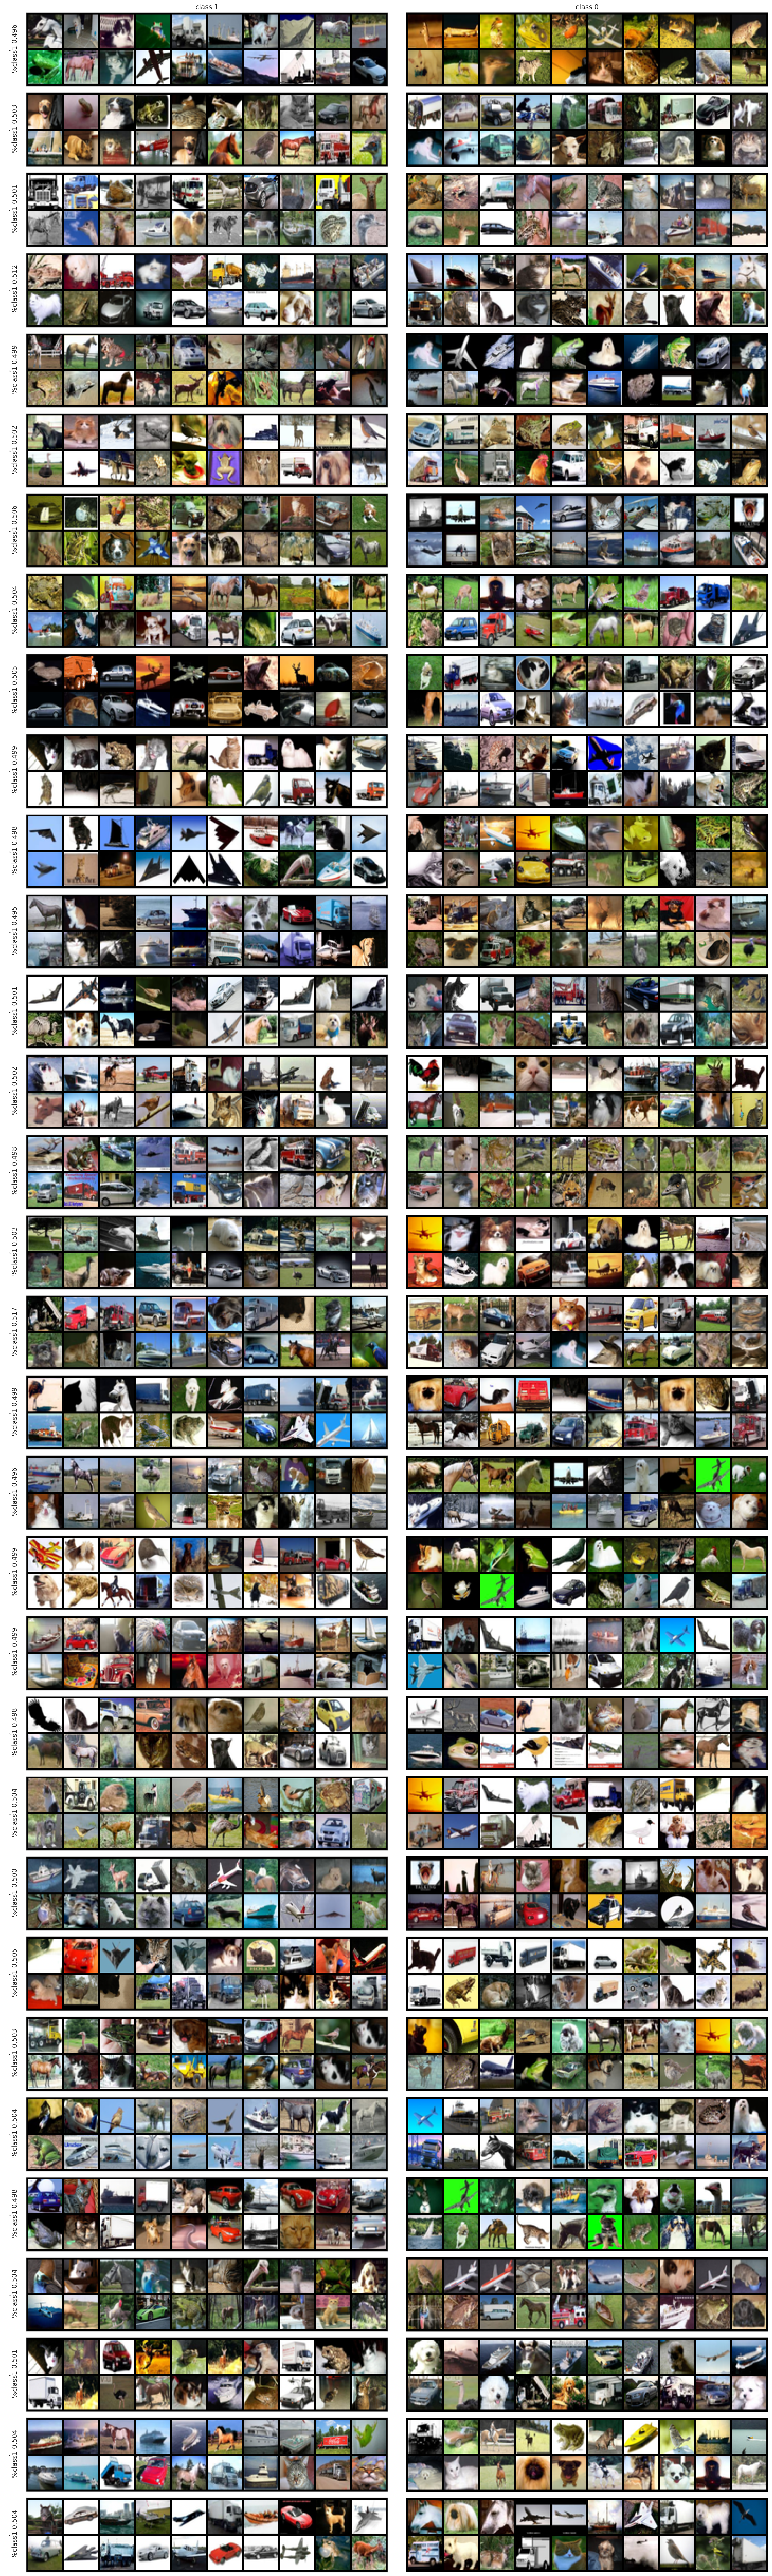

In [9]:
nb_tasks=tasks.size(1)
mean = torch.FloatTensor([x / 255.0 for x in [125.3, 123.0, 113.9]])[None, :, None, None]
std = torch.FloatTensor([x / 255.0 for x in [63.0, 62.1, 66.7]])[None, :, None, None]
xs_viz = xs * std + mean

fig,ax = plt.subplots(nb_tasks,2,figsize=(2*10,nb_tasks*2))


for tid in range(32):
    img_grid = torchvision.utils.make_grid(xs_viz[idx_topk[:,tid]],nrow=10)
    ax[tid,0].imshow(img_grid.permute(1,2,0))
    img_grid = torchvision.utils.make_grid(xs_viz[idx_botk[:,tid]],nrow=10)
    ax[tid,1].imshow(img_grid.permute(1,2,0))
    ylabel = f',\n %class1 {pct_class1[tid]:.3f}'
    ax[tid,0].set_ylabel(ylabel)

ax[0,0].set_title('class 1')
ax[0,1].set_title('class 0')

for i in range(nb_tasks):
    ax[i,0].grid(False)
    ax[i,0].set_yticklabels([])
    ax[i,0].set_xticklabels([])
    ax[i,1].axis("off")

plt.tight_layout()